## Import Concated Dataset

Going to look at the caption column and start filtering?

<BR>

2 main Goals with NLP tools-
1. Sentiment Analysis / Classification
2. Topic Modeling?

<BR>

Create a 'Word Cloud' viz for the final project?

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 # Select Latest Concated dataset for NLP Pipe
import os
import pandas as pd
import numpy as np
os.chdir('/content/drive/MyDrive/COVID Vaccine Instagram Analysis/NLP')

pd.set_option('display.max_columns', None) # spaces cols out nicely in pd
df = pd.read_csv('/content/drive/MyDrive/COVID Vaccine Instagram Analysis/Concated posts_data -- size5714.csv') #update filename in str with new data
#df = df[['username', 'caption', 'likes', 'comment_1', 'comment_2', 'bio']]


# After reviewing NAs added from col below to make 1-cell load in
for col in ['username', 'caption']:
  df = df[df[col].notnull()]

In [ ]:
# Exploring & Cleaning Data

# Check for NAs
print(df.isna().sum())
print('Before-', len(df))

# Drop rows where username is an NA or if no caption cannot do NLP on it! (Can have NAs in comments as that is variable)
for col in ['username', 'caption']:
  df = df[df[col].notnull()]

print('After-', len(df))

username         0
post_image       0
descrip       2426
caption          0
post_date     5402
likes          740
views         5402
comment_1        0
comment_2     2030
location      3280
bio           1272
following       39
followers       17
dtype: int64
Before- 5402
After- 5402


## Cleaning captions for NLP

<BR>

Below code-
- Removes special characters & numbers (can be changed easy) from captions & comments
- Filters out any Non-English Captions
- Appends sentiment (pos/neg) & objectivity scores for each caption in DF
- Tokenizes and returns both Dense NLP DF & CSR Matrix for Topic Modelling and whatever else...

In [ ]:
pip install langdetect #have to run this again if new kernel - environment is not registering saved

     |████████████████████████████████| 983kB 8.5MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=395cbb8c73744ed2184a74a37a03c77ee6d73f07d42aa8d87dc4b979a5fad34a
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
pip install text2emotion #need to run with each new kernel

     |████████████████████████████████| 61kB 4.0MB/s 
     |████████████████████████████████| 133kB 10.4MB/s 


In [ ]:
# CleanUp & Filter -- Try & Run once (it takes a while)
import re
import nltk
from nltk.tokenize import word_tokenize
import scipy
from textblob import TextBlob
import text2emotion as te
from langdetect import detect #classify languages based on captions!
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet as wn


#need depending on environment
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

lang_list, letters_only, senti, objecti = [], [], [], []
counter = 0


# Remove Specials & Classify Langs
for cap in df['caption']:
  counter += 1
  if counter/1000 == 0:
    print(f'{counter}')
  
  #special chars
  cap = re.sub("[^a-zA-Z]", " ", cap) # "[^a-zA-Z0-9#]" -- this one keeps nums & hashtags in (could do a sep analysis on hashtags later?)
  cap = cap.lower()
  letters_only.append(cap)
  
  #langs
  try:
    lang_list.append(detect(cap))
  except:
    lang_list.append(np.nan)
    pass


df['clean_cap'] = letters_only
df['lang'] = lang_list


# Repeat of above function for comments
letters_only = []
for cap in df['comment_1']:
  try:
    cap = re.sub("[^a-zA-Z]", " ", cap) # "[^a-zA-Z0-9#]" -- this one keeps nums & hashtags in (could do a sep analysis on hashtags later?)
    cap = cap.lower()
    cap = " ".join(cap.split()[1:]) #to remove username
    letters_only.append(cap)
  except TypeError:
    letters_only.append(np.nan)

df['comment_1'] = letters_only

letters_only = []
for cap in df['comment_2']:
  try:
    cap = re.sub("[^a-zA-Z]", " ", cap) # "[^a-zA-Z0-9#]" -- this one keeps nums & hashtags in (could do a sep analysis on hashtags later?)
    cap = cap.lower()
    cap = " ".join(cap.split()[1:]) #to remove username
    letters_only.append(cap)
  except TypeError:
    letters_only.append(np.nan)
df['comment_2'] = letters_only


print(f"# of unique languages = {len(df.lang.unique())}") #43 unique languages!
# df.lang.value_counts()
# df.lang.hist() -- blown up version of this hist might be nice in presentation's exploratory analysis


# Filter out dataset
df = df[df.lang == 'en']


# Add Polarity & Subjectivity Scores for Captions
cap_blob = [TextBlob(cap) for cap in df['clean_cap']]
df['polarity'] = [b.sentiment.polarity for b in cap_blob] #sentiment pos vs neg (-1 to 1)
df['polarity_score'] = [b.sentiment.polarity for b in cap_blob] # DELETE LATER! 
df['polarity'] = ['positive' if score > 0.1 
                             else 'negative' if score < 0
                                 else 'neutral' 
                                     for score in df['polarity_score']]
df['subjectivity_score'] = [b.sentiment.subjectivity for b in cap_blob] #subjectivity vs objectivity (0-1) 1 is highly subjective not obj
df['subjectivity'] = ['subjective' if score > 0.5 
                             else 'objective'
                                for score in df['subjectivity_score']]

# Polarity for Comments
c1_blob = [TextBlob(cap) for cap in df['comment_1']]
df['polarity_c1'] = [b.sentiment.polarity for b in c1_blob]
df['polarity_c1_score'] = [b.sentiment.polarity for b in c1_blob]
df['polarity_c1'] = ['positive' if score > 0.1 
                             else 'negative' if score < 0
                                 else 'neutral' 
                                     for score in df['polarity_c1_score']]

c2_blob = []
for cap in df['comment_2']:
  cap = str(cap)
  cap = TextBlob(cap)
  c2_blob.append(cap)
df['polarity_c2'] = [b.sentiment.polarity for b in c2_blob]
df['polarity_c2_score'] = [b.sentiment.polarity for b in c2_blob]
df['polarity_c2'] = ['positive' if score > 0.1 
                             else 'negative' if score < 0
                                 else 'neutral' 
                                     for score in df['polarity_c2_score']]



# Tokenize & Lemmatize
clean = []
txt = df.clean_cap.apply(word_tokenize)
stop_words = set(nltk.corpus.stopwords.words('english'))

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

for line in txt:
  for word in line:
    word = get_lemma(word)
  
  clean.append([token for token in line if token not in stop_words])

df['token_cap'] = clean


#"""     DELETE DOC STRING FOR FINAL ANALYSIS
# Add Emotion to Sentiment Analysis (in addition to the polarity & objectivity measure) - Takes about 12 min for this section
emotions = []
for cap in df['clean_cap']:
  emo = te.get_emotion(cap)
  max_emo = max(emo, key=emo.get)
  if all(value == 0 for value in emo.values()) == True:
    max_emo = 'none'
  emotions.append(max_emo)

df['emotion'] = emotions
"""

# Create NLP- DF & CSR
vectorizer = TfidfVectorizer()
df_vectorized = vectorizer.fit_transform(df.clean_cap)
features = vectorizer.get_feature_names()
instances = df_vectorized.toarray()
df_nlp = pd.DataFrame(columns=features, data=instances)
# df_nlp.head(15) -- takes a lil while to load, look @ dense version of document-term matrix
csr_nlp = scipy.sparse.csr_matrix(df_nlp.values)
"""

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
# of unique languages = 25


'\n\n# Create NLP- DF & CSR\nvectorizer = TfidfVectorizer()\ndf_vectorized = vectorizer.fit_transform(df.clean_cap)\nfeatures = vectorizer.get_feature_names()\ninstances = df_vectorized.toarray()\ndf_nlp = pd.DataFrame(columns=features, data=instances)\n# df_nlp.head(15) -- takes a lil while to load, look @ dense version of document-term matrix\ncsr_nlp = scipy.sparse.csr_matrix(df_nlp.values)\n'

In [ ]:
# Output above into CSV
os.chdir('/content/drive/MyDrive/COVID Vaccine Instagram Analysis') #post directly in main folder
df.to_csv('NLP_Filtered_Data.csv')
df.shape

(3971, 25)

KeyError: ignored

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


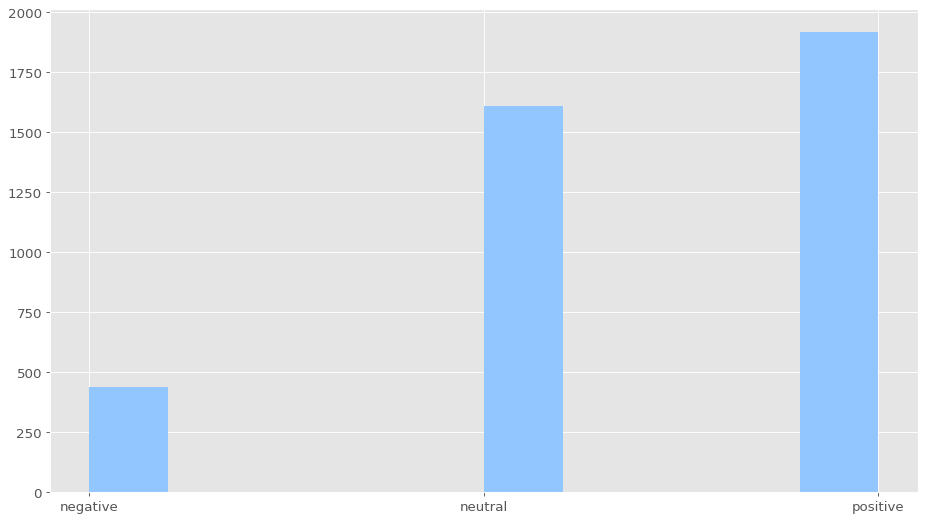

In [ ]:
# Import Plotting Packages & Set Global Params
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot') #looks nice without as well
plt.style.use('seaborn-pastel')
hfont = {'fontname':'Helvetica'}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['font.size'] = '12'
plt.figure(figsize=(14, 8), dpi=80)

df['polarity'].hist(rwidth=2)
#df['pol'].hist()
df['emotion'].hist(color='pink', rwidth=8)
plt.title("Caption Polarity & Emotion")

df['polarity'].value_counts()
df['emotion'].value_counts()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b7ff729d0>,
      dtype=object)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


<Figure size 1120x640 with 0 Axes>

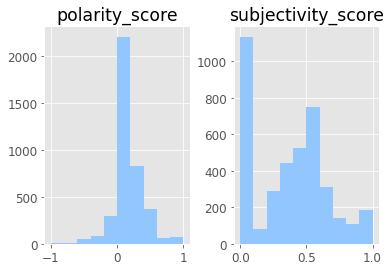

In [ ]:
# Examining Polarity & Subjectivity along cleaned caption
df[['clean_cap', 'polarity', 'subjectivity']]
plt.figure(figsize=(14, 8), dpi=80)
df[['polarity_score', 'subjectivity_score']].hist() #Add these plots to the presentation?

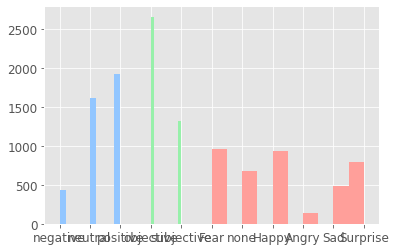

In [ ]:
# Category Distributions
df['polarity'].hist()
df['subjectivity'].hist()
df['emotion'].hist()

## Word Cloud
Create for final powerpoint

In [ ]:
from wordcloud import WordCloud, STOPWORDS

text = str(df['clean_cap'])

stops = ('maharashtra', 'clean_cap', 'covidvaccine', 'covidvacccine', 'vaccinated', 'dtype', '.', 'vaccine', 'fi', 'mid', 'san', 'st', 'saving'
       , 'diego', 'vaccin', 'new', 'Name', 'Length') #words to remove
for word in stops:
  STOPWORDS.add(word)


# Def a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");


# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Pastel1'
                    , collocations=False, stopwords=STOPWORDS).generate(text)


# Plot or Save
plot_cloud(wordcloud)
#wordcloud.to_file("wordcloud.png") #to save in current dir

## NLP Models

- Later Semantic Analysis (LSA) ??
- Visualize the Topic Model?
- Try Corex as opposed to LDA?

<BR>
<BR>

Ranga Notes:
- Maybe remove vaccine (trying to look @ effect of vaccine/sentiment not vaccine itself!) too much of one word can mess up LDA because it will assume it is most important! Try removing words from Word Cloud since large proportion!

- LDA is fussy, try playing with params and word inputs so we get a better or more informative topic

- Try drawing a "Topic Distance Map" for the themes

- AVOID OVERLAPPING OF THEMES! -- Keywords should not reoccur in multiple themes

<BR>

Example of LDA for Themes- https://dataconomy.com/2020/12/twitter-text-analytics-reveals-covid-19-vaccine-hesitancy-tweets-have-crazy-traction/

Example of Twitter Vax Study- https://towardsdatascience.com/sentiment-analysis-of-covid-19-vaccine-tweets-dc6f41a5e1af



In [ ]:
# def Corpus & save for later use
from gensim import corpora
dictionary = corpora.Dictionary(df.token_cap)
corpus = [dictionary.doc2bow(text) for text in df.token_cap]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [ ]:
# Look for n-topics in data -- OLD VERSION
import gensim

n_topics = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

In [ ]:
# Look at words in first entry of corpus?
[[(dictionary[i], freq) for i, freq in doc] for doc in corpus[:1]]

In [ ]:
!pip install pyLDAvis #re-run every kernel (do not need restart to use packages)

     |████████████████████████████████| 1.7MB 8.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 35.4MB/s 
     |████████████████████████████████| 15.3MB 322kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=161170865fa1fe3d2aed363381a3d08e5ac4f77f25750c2b0c4973d3fa03c171
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

In [ ]:
pip install numexpr

In [ ]:
# pyLDAvis Visualization
import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

from pprint import pprint

import spacy

import pickle
import re 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


dictionary = corpora.Dictionary(df.token_cap)
corpus = [dictionary.doc2bow(text) for text in df.token_cap]

# Build LDA model
num_topics = 20
lda_model = LdaModel(corpus=corpus,
                   id2word=dictionary,
                   num_topics=num_topics, 
                   random_state=1,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)
doc_lda = lda_model[corpus]

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

In [ ]:
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, 
                              corpus=corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [ ]:
# Given Topic Groupings / Salient Terms above, def Priors for Guided LDA
# Guided LDA link- https://www.kaggle.com/nvpsani/topic-modelling-using-guided-lda
topic_df = vis.topic_info

# Get Topic terms
# t1 = topic_df.loc[topic_df['Category'] == 'Topic1'] ##### MAY ALL BE NON-ESSENTIAL? -- DEL LATER
# t3 = topic_df.loc[topic_df['Category'] == 'Topic3'] ##### MAY ALL BE NON-ESSENTIAL? -- DEL LATER
# t5 = topic_df.loc[topic_df['Category'] == 'Topic5'] ##### MAY ALL BE NON-ESSENTIAL? -- DEL LATER
t11 = topic_df.loc[topic_df['Category'] == 'Topic11'] #conspiracy / CCP topic?


# Define Topics from list of Terms
conspiracy_topic = list(t11['Term'].unique()) ['drlimengyuan', 'ccp']
pfizer_topic = ['pfizer', 'pfizervaccine']
moderna_topic = ['moderna', 'modernavaccine']
johnson_topic = ['johnson', 'johnsonandjohnson']
astrazeneca_topic = ['astrazeneca', 'astrazenecavaccine']
side_effects_topic = ['vaccine', 'week', 'allergic', 'reaction', 'felt', 'dose', 'shot']

topics_list = [conspiracy_topic
             , pfizer_topic
             , moderna_topic
             , johnson_topic
             , astrazeneca_topic
             , side_effects_topic  ]

NameError: ignored

In [ ]:
!pip install guidedlda

     |████████████████████████████████| 2.1MB 13.5MB/s 
  ERROR: Failed building wheel for guidedlda
  Running setup.py clean for guidedlda
Failed to build guidedlda
    Running setup.py install for guidedlda ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-uxba9rvj/guidedlda/setup.py'"'"'; __file__='"'"'/tmp/pip-install-uxba9rvj/guidedlda/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-sio_1klp/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [ ]:
pip install guidedlda

ModuleNotFoundError: ignored

In [ ]:
pip install corextopic

In [ ]:
# Corex or Guided LDA -- Additional Topic Modeler or one to replace the above
# Link- https://pypi.org/project/corextopic/#:~:text=Correlation%20Explanation%20(CorEx)%20is%20a,depending%20on%20a%20user's%20needs.
from corextopic import corextopic as ct




# Sparse matrices are also supported
#X = ss.csr_matrix(X)
X = csr_nlp
# Word labels for each column can be provided to the model -- OPTIONAL
words = df_nlp.columns

# Document labels for each row can be provided
docs = ['conspiracy_topic', 'pfizer_topic', 'moderna_topic', 'johnson_topic', 'astrazeneca_topic', 'side_effects_topic']

# Train the CorEx topic model
topic_model = ct.Corex(n_hidden=6)  # Define the number of latent (hidden) topics to use.
topic_model.fit(X, words=words, docs=docs)

In [ ]:
# Get Topics

topics = topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    # w: word, mi: mutual information, s: sign
    topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
    # Unpack the info about the topic
    words,mis,signs = zip(*topic)    
    # Print topic
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)

1: ccp, yanlimeng, drlimengyan, bannon, agenda, ccpvirus, gtv, whistleblowingmovement, warroom, warroompandemic
2: the, to, and, that, it, was, of, you, we, have
3: leslieodomjr, daveeddiggs, hamilton, alexanderhamilton, aaronburr, linmanuelmiranda, hamiltonmemes, andpeggy, angelicaschuyler, originalbroadwaycast
4: japan, lgbtq, covidprotection, firstjab, dailyphoto, steven, goawaycorona, ptbirjumaharajji, pfine, khatriji
5: mandydolldoll, kidscollection, ek, foryourpage, loseyourselfinthemoment, slimshady, cghealth, healthychhattisgarh, cgpublichealth, readytogo
6: cases, travellers, deaths, reported, gotmyshot, coviddeaths, covidrecoveries, asiaexpressnews, asiaexpressaurangabad, asiaexpress


In [ ]:
?vt.vis_rep

/usr/local/lib/python3.7/dist-packages/google/colab/_inspector.py:386: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  oname + inspect.formatargspec(*argspec, formatvalue=formatvalue))


In [ ]:
# Viz Topics
from corextopic import vis_topic as vt
vt.vis_rep(topic_model, column_label=words, prefix='topic-model-example')

Print topics in text file


IndexError: ignored